Iteration 0, Loss: 0.0505923330783844, PSNR: 12.959152221679688
Iteration 100, Loss: 0.026694411411881447, PSNR: 15.735796928405762
Iteration 200, Loss: 0.020008428022265434, PSNR: 16.987869262695312
Iteration 300, Loss: 0.012880095280706882, PSNR: 18.90081024169922
Iteration 400, Loss: 0.01279551163315773, PSNR: 18.92942237854004
Iteration 500, Loss: 0.012743559665977955, PSNR: 18.947092056274414
Iteration 600, Loss: 0.0107429139316082, PSNR: 19.688779830932617
Iteration 700, Loss: 0.01371728628873825, PSNR: 18.627317428588867
Iteration 800, Loss: 0.010059027932584286, PSNR: 19.97443962097168
Iteration 900, Loss: 0.010463234968483448, PSNR: 19.803340911865234
Iteration 1000, Loss: 0.01640675775706768, PSNR: 17.84977149963379
Iteration 1100, Loss: 0.01328548789024353, PSNR: 18.766223907470703
Iteration 1200, Loss: 0.00837294664233923, PSNR: 20.771217346191406
Iteration 1300, Loss: 0.009035835973918438, PSNR: 20.44031524658203
Iteration 1400, Loss: 0.009778696112334728, PSNR: 20.0971908

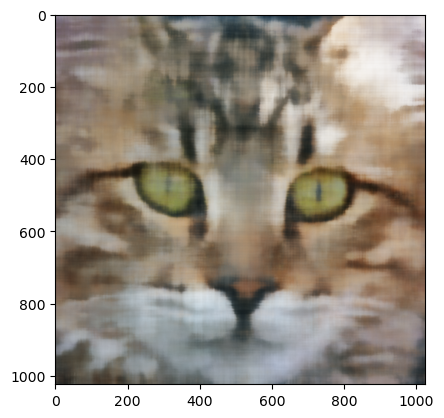

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as imageio
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]

# Positional Encoding (NeRF-style)
class PositionalEncodingNeRF(nn.Module):
    def __init__(self, L=10):
        super(PositionalEncodingNeRF, self).__init__()
        self.L = L

    def forward(self, x):
        out = []
        for i in range(self.L):
            out.append(torch.sin((2. ** i) * x * np.pi))
            out.append(torch.cos((2. ** i) * x * np.pi))
        return torch.cat(out, dim=-1)

# Define the NeRF-style network architecture with skip connections
class NeRFNetwork(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dims=[256] * 8, pos_enc_L=10, dir_enc_L=4):
        super(NeRFNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.pos_enc = PositionalEncodingNeRF(L=pos_enc_L)
        self.dir_enc = PositionalEncodingNeRF(L=dir_enc_L)

        # input dimensionality is 2 for (x, y), multiplied by 2 for sin and cos, and by L for number of frequencies
        encoded_dim = inp_dim * 2 * pos_enc_L
        self.fc_in = nn.Linear(encoded_dim, hid_dims[0])

        # hidden layers with skip connection to the fifth layer
        for i in range(len(hid_dims) - 1):
            if i == 4:  # skip connection to the 5th layer
                self.layers.append(nn.Linear(hid_dims[i] + encoded_dim, hid_dims[i + 1]))
            else:
                self.layers.append(nn.Linear(hid_dims[i], hid_dims[i + 1]))

        # The feature vector is the second to last layer's output
        self.fc_feature = nn.Linear(hid_dims[-2], hid_dims[-1])

        # Output layer for volume density σ with ReLU to ensure non-negativity
        self.fc_density = nn.Linear(hid_dims[-1], 1)

        # Directional encoding for the view direction d
        dir_encoded_dim = 3 * 2 * dir_enc_L
        self.fc_dir_in = nn.Linear(dir_encoded_dim, hid_dims[-1])
        
        # Output layer for RGB color
        self.fc_dir_out = nn.Linear(hid_dims[-1] * 2, out_dim)  # * 2 for concatenating feature vector and dir_enc

    def forward(self, x, d):
        # Position encoding
        encoded_x = self.pos_enc(x)
        z = F.relu(self.fc_in(encoded_x))
        for i, layer in enumerate(self.layers):
            if i == 4:  # This is the skip-connected layer
                z = torch.cat([z, encoded_x], dim=1)
            z = F.relu(layer(z))
        
        # Feature vector
        feature_vector = F.relu(self.fc_feature(z))
        
        # Volume density σ
        density = F.relu(self.fc_density(feature_vector))

        # Direction encoding
        encoded_d = self.dir_enc(d)
        dir_input = F.relu(self.fc_dir_in(encoded_d))

        # Concatenate feature vector with directionally encoded input
        combined = torch.cat([feature_vector, dir_input], dim=1)

        # Output layer for RGB color with sigmoid activation
        rgb = torch.sigmoid(self.fc_dir_out(combined))

        return density, rgb

# Custom dataset to feed into DataLoader
class CustomImageDataset(Dataset):
    def __init__(self, img, dir_enc_L=4):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)
        directions = np.random.normal(size=(h, w, 3))  # Placeholder for directions, replace with actual directions if available

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.D = torch.from_numpy(directions.reshape(-1, 3)).float()
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0  # Normalize to [0, 1] range, shape (h*w, 3)
        #self.dir_enc = PositionalEncodingNeRF(L=dir_enc_L)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.D[idx, :], self.Y[idx, :]

def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()

def compute_loss(out, y):
    return F.mse_loss(out, y)

dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the network
net = NeRFNetwork(inp_dim=2, out_dim=3, hid_dims=[256] * 8, pos_enc_L=10, dir_enc_L=4)
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)

# Training loop
data_iter = iter(loader)
for iteration in range(30000):  # Train for 30000 iterations
    try:
        x, d, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, d, y = next(data_iter)

    opt.zero_grad()
    density, out_rgb = net(x, d)
    loss_rgb = F.mse_loss(out_rgb, y)
    loss_density = torch.mean(F.relu(-density))  # Encourage density to be non-negative
    loss = loss_rgb + loss_density
    loss.backward()
    opt.step()
    scheduler.step()

    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {-10 * torch.log10(loss_rgb)}")
    if -10 * torch.log10(loss_rgb) > 26:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {-10 * torch.log10(loss_rgb)}")
        break

def create_image(resolution, net):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)

    # Generate a direction tensor, similar to the one used in the training stage
    directions = np.random.normal(size=(resolution, resolution, 3))

    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    d = torch.from_numpy(directions.reshape(-1, 3)).float()  # New direction tensor

    density, out_rgb = net(x, d)
    rgb = out_rgb.reshape(resolution, resolution, 3)  # Used output from network

    rgb = torch.clamp(rgb, 0, 1)
    return rgb.detach().cpu().numpy()

out_img = create_image(1024, net)
plt.imshow(out_img)
plt.show()

